# Calculating travel time to ports and border crossings in Georgia

We have a map of a series of road improvements in Georgia, and we need to determine how these improve access to border crossings and ports

In [1]:
import sys, os, json
import rasterio, overturemaps

import pandas as pd
import geopandas as gpd
import skimage.graph as graph

from shapely.geometry import Point, box

from space2stats_client import Space2StatsClient

sys.path.insert(0, r"C:\WBG\Work\Code\GOSTrocks\src")
import GOSTrocks.rasterMisc as rMisc
import GOSTrocks.dataMisc as dMisc
import GOSTrocks.mapMisc as mapMisc
import GOSTrocks.ntlMisc as ntlMisc
from GOSTrocks.misc import tPrint

sys.path.append(r"C:\WBG\Work\Code\GOSTnetsraster\src")
import GOSTnetsraster.market_access as ma
import GOSTnetsraster.conversion_tables as speed_tables

s2s_client = Space2StatsClient(verify_ssl=False)

%load_ext autoreload
%autoreload 2

In [2]:
# Input parameters
m_crs = "ESRI:54009" # Need to project data to a metres-based projection

# Define input data
base_folder = "C:/WBG/Work/Projects/GEO_Road_Improvements"
landcover_file = os.path.join(base_folder, "DATA", 'ESA_Globcover.tif')
# These are the digitized road segements that have been improved
road_segments_file = os.path.join(base_folder, "DATA", "impacted_osm_roads.gpkg")
transport_network = os.path.join(base_folder, "DATA", "Overture", "transport_network.gpkg")
major_roads_file = os.path.join(base_folder, "DATA", "Overture", "major_roads.gpkg")
major_roads_updated_file = os.path.join(base_folder, "DATA", "major_roads_final.shp")
border_crossings_file = os.path.join(base_folder, "DATA", "Border_Crossings.shp")
urban_centers_file = os.path.join(base_folder, "DATA", "GEO_urban_centers.gpkg")
local_admin_boundaries_file = os.path.join(base_folder, "DATA", "GEO_admin_boundaries.gpkg")

# WorldPop 2020 constrained, projected to m_crs
pop_file = os.path.join(base_folder, "DATA", "geo_pop_2025_CN_100m_R2025A_v1.tif")
pop_file_proj = pop_file.replace(".tif", "_proj.tif")

# https://datacatalog.worldbank.org/int/search/dataset/0038118/Global---International-Ports
port_file = os.path.join(base_folder, "DATA", "GEO_ports.gpkg")

# administrative bounadaries are used to summarize population
''' # Stupid SSL errors
adm2 = s2s_client.fetch_admin_boundaries("GEO", 'ADM2')
adm1 = s2s_client.fetch_admin_boundaries("GEO", 'ADM1')
'''
if not os.path.exists(local_admin_boundaries_file):
    global_adm2_file =  r"C:\WBG\Work\data\ADMIN\NEW_WB_BOUNDS\FOR_PUBLICATION\geojson\WB_GAD_ADM2.geojson"
    adm2 = gpd.read_file(global_adm2_file)
    adm2 = adm2.loc[adm2['ISO_A3'] == 'GEO']
    adm2 = adm2.to_crs(m_crs)
    adm2.to_file(local_admin_boundaries_file, driver="GPKG")
else:
    adm2 = gpd.read_file(local_admin_boundaries_file)


# Define output files
friction_folder = os.path.join(base_folder, "DATA", "FRICTION")
results_folder = os.path.join(base_folder, "RESULTS")
overture_folder = os.path.join(base_folder, "DATA", "Overture")
for cFolder in [friction_folder, results_folder, overture_folder]:
    if not os.path.exists(cFolder):
        os.makedirs(cFolder)    

pre_friction_file = os.path.join(friction_folder, 'FRICTION_pre_intervention.tif')
post_friction_file_1 = os.path.join(friction_folder, 'FRICTION_post_intervention_1.tif')
post_friction_file_2 = os.path.join(friction_folder, 'FRICTION_post_intervention_2.tif')
post_friction_file_3 = os.path.join(friction_folder, 'FRICTION_post_intervention_3.tif')

# Read in data
ports = gpd.read_file(port_file).to_crs(m_crs)
if not os.path.exists(landcover_file):
    global_landcover = r"R:\GLOBAL\LCVR\Globcover\2015\ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif"
    in_lc = rasterio.open(global_landcover)
    temp_landcover_file = landcover_file.replace(".tif", "_temp.tif")
    local_lc = rMisc.clipRaster(in_lc, adm2, temp_landcover_file)
    temp_lc = rasterio.open(temp_landcover_file)
    proj_res = rMisc.project_raster(temp_lc, m_crs)
    with rasterio.open(landcover_file, 'w', **proj_res[1]) as outR:
        outR.write(proj_res[0])

in_lc = rasterio.open(landcover_file)
if not os.path.exists(pop_file_proj):
    in_pop = rasterio.open(pop_file)
    if in_pop.crs != in_lc.crs:
        proj_res = rMisc.standardizeInputRasters(in_pop, in_lc, pop_file_proj)    
else:
    in_pop = rasterio.open(pop_file_proj)

if not os.path.exists(urban_centers_file):
    urban_centers_global = r"C:\WBG\Work\data\URBAN\GHS_UCDB_GLOBE_R2024A.gpkg"
    global_urban_centers = gpd.read_file(urban_centers_global)
    urban_centers = global_urban_centers.loc[global_urban_centers['GC_CNT_GAD_2025'] == 'Georgia']
    urban_centers.to_file(urban_centers_file, driver="GPKG")
else:
    urban_centers = gpd.read_file(urban_centers_file)

In [3]:
# Downlaod worldcover data
tiles_geojson = r"C:\WBG\Work\data\LCVR\esa_worldcover_grid.geojson"
in_tiles = gpd.read_file(tiles_geojson)
sel_tiles = in_tiles.loc[in_tiles.intersects(adm2.union_all())]

tile_path = "s3://esa-worldcover/v200/2021/map/ESA_WorldCover_10m_2021_v200_{tile}_Map.tif"
out_folder = os.path.join(base_folder, "DATA", "WorldCover")
for idx, row in sel_tiles.iterrows():
    cur_tile_path = tile_path.format(tile=row['ll_tile'])
    cur_out = os.path.join(out_folder, f"WorldCover_{row['ll_tile']}.tif")
    if not os.path.exists(cur_out):
        command = f"aws s3 --no-sign-request --no-verify-ssl cp {cur_tile_path} {cur_out}"
        print(command)

In [5]:
# Download roads from Overture
#Download transport network
if not os.path.exists(transport_network):    
    bbox = adm2.total_bounds.tolist()  # minx, miny, maxx, maxy
    transport = overturemaps.record_batch_reader("segment", bbox).read_all()
    transport_df = gpd.GeoDataFrame.from_arrow(transport)
    transport_df.crs = 4326
    transport_df.loc[:, ["id", "class", "subtype", "road_surface", "speed_limits", "width_rules", "geometry"]].to_file(transport_network, driver="GPKG")

# process transport to a) remove roads outside IRAQ and b) remove all roads of OSMLR class 3 and 4
if not os.path.exists(major_roads_file):
    roads = gpd.read_file(transport_network)
    roads['OSMLR_class'] = roads['class'].map(speed_tables.OSMLR_Classes)
    roads_joined = gpd.sjoin(roads, adm2, how="inner", predicate="intersects")
    major_roads = roads_joined.loc[roads_joined['OSMLR_class'].isin(['OSMLR level 1', 'OSMLR level 2']), roads.columns]
    major_roads.to_file(major_roads_file, driver="GPKG", index=False)

# After downloading the major roads, some manual edits were made to the major roads shapefile to add missing segments and update road classes.
major_roads = gpd.read_file(major_roads_updated_file)
major_roads['OSMLR_clas'].fillna('OSMLR level 1', inplace=True)
major_roads['class'].fillna('motorway', inplace=True)

# Process roads to create pre and post friction surfaces
major_roads['speed'] = major_roads['class'].map(speed_tables.osm_speed_dict)
major_roads['speed'] = major_roads['speed'].fillna(10.0)
major_roads['new_speed_1'] = major_roads['speed'].values
major_roads['new_speed_2'] = major_roads['speed'].values
major_roads['new_speed_3'] = major_roads['speed'].values
# For all the roads with a Status value, increase new_speed by 20%
major_roads.loc[major_roads['Scenario'] == 1, 'new_speed_1'] = major_roads.loc[major_roads['Scenario'] == 1, 'new_speed_1'] * 1.5
major_roads.loc[major_roads['Scenario'] == 2, 'new_speed_2'] = major_roads.loc[major_roads['Scenario'] == 2, 'new_speed_2'] * 1.5
major_roads.loc[major_roads['Scenario'].isin([1,2]), 'new_speed_3'] = major_roads.loc[major_roads['Scenario'].isin([1,2]), 'new_speed_3'] * 1.5

lc_speed_table = speed_tables.esaacci_landcover

C:\Users\WB411133\AppData\Local\Temp\ipykernel_46416\2456396756.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  major_roads['OSMLR_clas'].fillna('OSMLR level 1', inplace=True)
C:\Users\WB411133\AppData\Local\Temp\ipykernel_46416\2456396756.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

In [ ]:
# Delete existing friction surfaces to force re-generation
for cFile in [pre_friction_file, post_friction_file_1, post_friction_file_2, post_friction_file_3]:
    if os.path.exists(cFile):
        os.remove(cFile)

# Generate pre-intervention friction surface
if not os.path.exists(pre_friction_file):
    pre_roads = major_roads.copy()
    if pre_roads.crs != in_lc.crs:
        pre_roads = pre_roads.to_crs(in_lc.crs)
    pre_friction = ma.generate_roads_lc_friction(in_lc, pre_roads, lc_travel_table=lc_speed_table, 
                             out_file=pre_friction_file, resolution=in_lc.res[0], speed_col='speed')

pre_friction = rasterio.open(pre_friction_file)

# Generate post-intervention friction surface
if not os.path.exists(post_friction_file_1):
    post_roads = major_roads.copy()  
    if post_roads.crs != in_lc.crs:
        post_roads = post_roads.to_crs(in_lc.crs)
    post_friction = ma.generate_roads_lc_friction(in_lc, post_roads, lc_travel_table=lc_speed_table, 
                              out_file=post_friction_file_1, resolution=in_lc.res[0], speed_col='new_speed_1')
    
post_friction_1 = rasterio.open(post_friction_file_1)

# Generate post-intervention friction surface
if not os.path.exists(post_friction_file_2):
    post_roads = major_roads.copy()  
    if post_roads.crs != in_lc.crs:
        post_roads = post_roads.to_crs(in_lc.crs)
    post_friction = ma.generate_roads_lc_friction(in_lc, post_roads, lc_travel_table=lc_speed_table, 
                              out_file=post_friction_file_2, resolution=in_lc.res[0], speed_col='new_speed_2')
    
post_friction_2 = rasterio.open(post_friction_file_2)

# Generate post-intervention friction surface
if not os.path.exists(post_friction_file_3):
    post_roads = major_roads.copy()  
    if post_roads.crs != in_lc.crs:
        post_roads = post_roads.to_crs(in_lc.crs)
    post_friction = ma.generate_roads_lc_friction(in_lc, post_roads, lc_travel_table=lc_speed_table, 
                              out_file=post_friction_file_3, resolution=in_lc.res[0], speed_col='new_speed_3')
post_friction_3 = rasterio.open(post_friction_file_3)

In [ ]:
def calc_tt_diff_3_scenarios(prefix, dests, in_pop, pre_friction, post_friction_1, post_friction_2, post_friction_3, adm2, results_folder):

    # Calculate pre-intervention, population-weighted travel times summarized at admin 2
    frictionD = pre_friction.read()[0,:,:]
    frictionD = frictionD * pre_friction.res[0]
    mcp = graph.MCP_Geometric(frictionD)

    ports = gpd.read_file(port_file).to_crs(m_crs)
    ports = ports.to_crs(pre_friction.crs)

    pre_tt_ports = ma.summarize_travel_time_populations(in_pop, pre_friction, dests, mcp, adm2, 
                                                        out_tt_file=os.path.join(results_folder, f"{prefix}_PRE_travel_time.tif"))
    pre_tt_ports.to_file(os.path.join(results_folder, f"{prefix}_PRE_ADM2_tt.gpkg"), driver="GPKG")
    pd.DataFrame(pre_tt_ports.drop(["geometry"], axis=1)).to_csv(os.path.join(results_folder, f"{prefix}_PRE_ADM2_tt.csv"))

    # Run analysis using post_treatment friction surface
    frictionD = post_friction_1.read()[0,:,:]
    frictionD = frictionD * post_friction_1.res[0]
    mcp = graph.MCP_Geometric(frictionD)

    post_tt_ports_1 = ma.summarize_travel_time_populations(in_pop, post_friction_1, dests, mcp, adm2, 
                                                        out_tt_file=os.path.join(results_folder, f"{prefix}_POST_travel_time_1.tif"))
    post_tt_ports_1.to_file(os.path.join(results_folder, f"{prefix}_POST_ADM2_tt_1.gpkg"), driver="GPKG")
    pd.DataFrame(post_tt_ports_1.drop(["geometry"], axis=1)).to_csv(os.path.join(results_folder, f"{prefix}_POST_ADM2_tt_1.csv"))

    # Run analysis using post_treatment friction surface 2
    frictionD = post_friction_2.read()[0,:,:]
    frictionD = frictionD * post_friction_2.res[0]
    mcp = graph.MCP_Geometric(frictionD)    
    post_tt_ports_2 = ma.summarize_travel_time_populations(in_pop, post_friction_2, dests, mcp, adm2, 
                                                        out_tt_file=os.path.join(results_folder, f"{prefix}_POST_travel_time_2.tif"))
    post_tt_ports_2.to_file(os.path.join(results_folder, f"{prefix}_POST_ADM2_tt_2.gpkg"), driver="GPKG")
    pd.DataFrame(post_tt_ports_2.drop(["geometry"], axis=1)).to_csv(os.path.join(results_folder, f"{prefix}_POST_ADM2_tt_2.csv"))

    # Run analysis using post_treatment friction surface 3
    frictionD = post_friction_3.read()[0,:,:]
    frictionD = frictionD * post_friction_3.res[0]
    mcp = graph.MCP_Geometric(frictionD)    
    post_tt_ports_3 = ma.summarize_travel_time_populations(in_pop, post_friction_3, dests, mcp, adm2, 
                                                        out_tt_file=os.path.join(results_folder, f"{prefix}_POST_travel_time_3.tif"))
    post_tt_ports_3.to_file(os.path.join(results_folder, f"{prefix}_POST_ADM2_tt_3.gpkg"), driver="GPKG")
    pd.DataFrame(post_tt_ports_3.drop(["geometry"], axis=1)).to_csv(os.path.join(results_folder, f"{prefix}_POST_ADM2_tt_3.csv"))

    # Calculate difference in travel times and percentage change
    tt_diff = post_tt_ports_1.copy()

    for col in ['total_pop', 'pop_30', 'pop_60', 'pop_120', 'pop_180', 'pop_240', 'tt_pop_w']:
        tt_diff[f'{col}_1'] = pre_tt_ports[col] - post_tt_ports_1[col]
        tt_diff[f'{col}_2'] = pre_tt_ports[col] - post_tt_ports_2[col]
        tt_diff[f'{col}_3'] = pre_tt_ports[col] - post_tt_ports_3[col]
        
    tt_diff.to_file(os.path.join(results_folder, f"{prefix}_TT_diff_ADM2_tt.gpkg"), driver="GPKG")
    pd.DataFrame(tt_diff.drop(["geometry"], axis=1)).to_csv(os.path.join(results_folder, f"{prefix}_TT_diff_ADM2_tt.csv"))

## Calculate travel time to destinations

In [ ]:
if urban_centers.crs != m_crs:
    urban_centers = urban_centers.to_crs(m_crs)
urban_centers['geometry'] = urban_centers['geometry'].centroid
Tbilisi_city = urban_centers.loc[urban_centers['GC_UCN_MAI_2025'] == 'Tbilisi']
in_pop = rasterio.open(pop_file.replace(".tif", "_proj.tif"))

In [ ]:
calc_tt_diff_3_scenarios("ports", ports, in_pop, pre_friction, post_friction_1, post_friction_2, post_friction_3, adm2, results_folder)
calc_tt_diff_3_scenarios("borders", gpd.read_file(border_crossings_file).to_crs(m_crs), in_pop, pre_friction, post_friction_1, post_friction_2, post_friction_3, adm2, results_folder)
calc_tt_diff_3_scenarios("urban_centers", urban_centers.to_crs(m_crs), in_pop, pre_friction, post_friction_1, post_friction_2, post_friction_3, adm2, results_folder)
calc_tt_diff_3_scenarios("Tbilisi", Tbilisi_city.to_crs(m_crs), in_pop, pre_friction, post_friction_1, post_friction_2, post_friction_3, adm2, results_folder)

In [27]:
# aggregate tabular results across scenarios
good_cols = ['total_pop','pop_30','pop_60','pop_120','pop_180','pop_240','tt_pop_w']
csv_results = [x for x in os.listdir(results_folder) if x.endswith(".csv")]
combo_results = []
for c_file in csv_results:
    name_split = c_file.split("_")
    dest = name_split[0]
    scenario = name_split[-1].replace(".csv", "")
    if scenario == 'tt':
        scenario = "PRE"
    else:
        scenario = f"POST_{scenario}"
    diff = False if "diff" in name_split[2] else True
    if diff:
        cur_df = pd.read_csv(os.path.join(results_folder, c_file))
        sel_df = cur_df.loc[:,good_cols].copy()
        sel_df.columns = [f"{col}_{dest}_{scenario}" for col in sel_df.columns]
        sel_df['ADM2CD_c'] = cur_df['ADM2CD_c'].values
        combo_results.append(sel_df)

final_df = pd.concat(combo_results, axis=1)
final_df = final_df.loc[:,~final_df.columns.duplicated()]
final_df.to_csv(f'{results_folder}_aggregated_travel_time_results.csv', index=False)

## Map results

In [7]:
wb_gad_service = "https://services.arcgis.com/iQ1dY19aHwbSDYIF/arcgis/rest/services/World_Bank_Global_Administrative_Divisions/FeatureServer"
adm0 = dMisc.gdf_esri_service(wb_gad_service, layer=1, verify_ssl=False)
adm1 = dMisc.gdf_esri_service(wb_gad_service, layer=2, verify_ssl=False)
adm0_lines = dMisc.gdf_esri_service(wb_gad_service, layer=0, verify_ssl=False)
other_countries = adm0.loc[adm0['ISO_A3'] != 'GEO']

c:\WBG\Anaconda3\envs\s2s_ingest\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'services.arcgis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\WBG\Anaconda3\envs\s2s_ingest\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'services.arcgis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\WBG\Anaconda3\envs\s2s_ingest\lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'services.arcgis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\WBG\Anaconda3\envs\

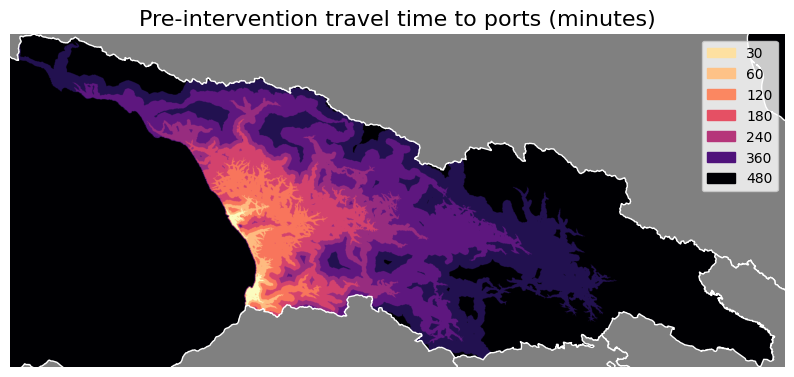

In [9]:
tt_raster_to_plot = os.path.join(results_folder, "ports_PRE_travel_time.tif")
ttR = rasterio.open(tt_raster_to_plot)
if other_countries.crs != ttR.crs:
    other_countries = other_countries.to_crs(ttR.crs)
try:
    plt.close('all')
except:
    pass

plt, fig, ax = mapMisc.static_map_raster(ttR, thresh=[30, 60, 120, 180, 240, 360, 480], 
                                         reverse_colormap=True)
other_countries.plot(ax=ax, facecolor='grey', edgecolor="white")
# Set bounding box to Georgia
b = list(ttR.bounds)
# Add ocean
#ocean = gpd.GeoDataFrame(geometry=[box(*b)], crs=ttR.crs)
#ocean = ocean.difference(adm0.union_all())
#ocean.plot(ax=ax, color="midnightblue")    
ax.set_xlim(b[0], b[2])
ax.set_ylim(b[1], b[3])
ax.set_axis_off()
ax.set_title("Pre-intervention travel time to ports (minutes)", fontsize=16)
plt.show()

KeyboardInterrupt: 

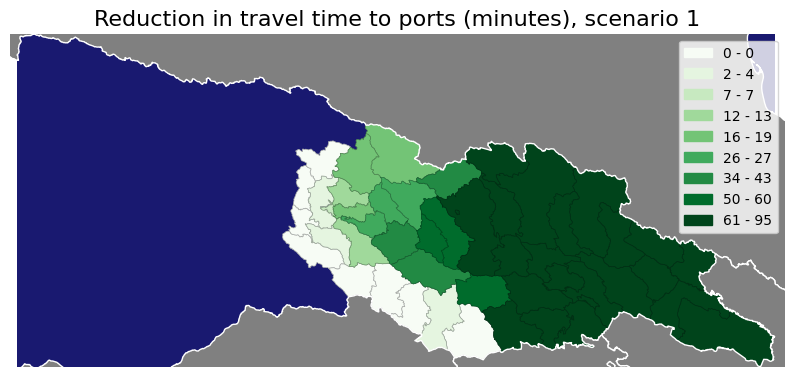

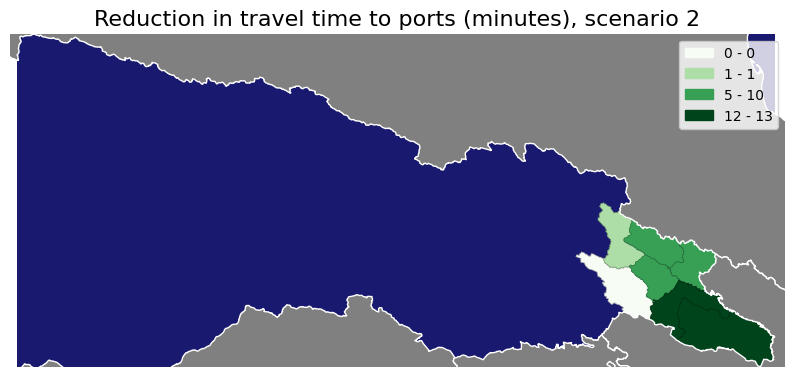

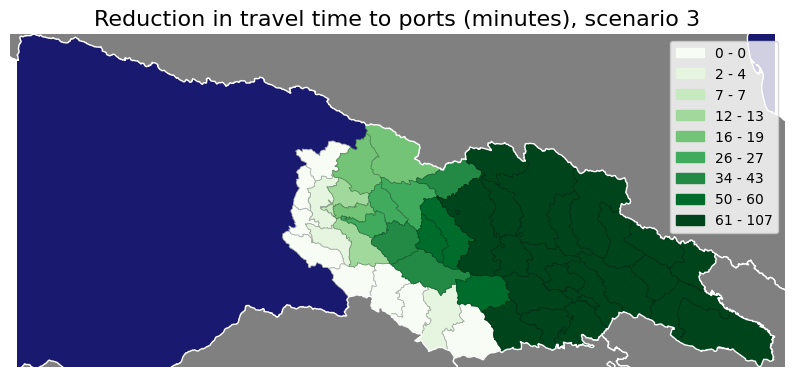

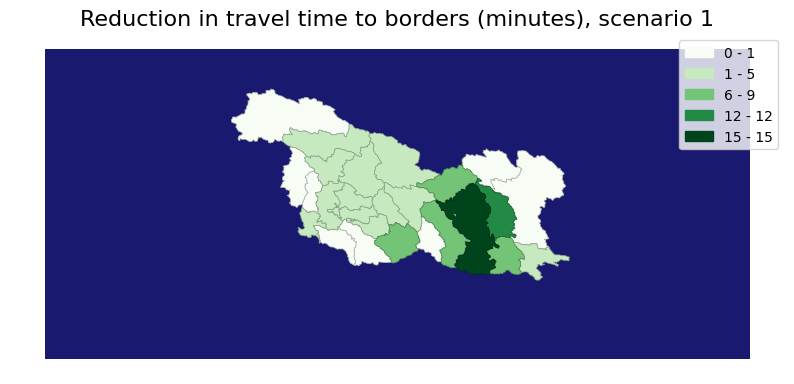

In [ ]:
# Map change in travel time at adm2 level
# drop duplicate columns in final_df
out_folder = os.path.join(base_folder, "MAPS")
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

adm2_map = pd.merge(adm2, final_df, on='ADM2CD_c')
for dest in ['ports', 'borders', 'urban', 'Tbilisi']:
    for scenario in ['1', '2', '3']:
        adm2_map['map_column'] = adm2_map[f'tt_pop_w_{dest}_PRE'] - adm2_map[f'tt_pop_w_{dest}_POST_{scenario}']
        plt, fig, ax = mapMisc.static_map_vector(adm2_map, map_column='map_column', colormap='Greens', 
                                                 thresh=[-1, 0, 1, 5, 10, 15, 20, 30, 45, 60, 1000],
                                                 add_basemap=False, add_wb_borders_lines=False)

        ax.set_title(f"Reduction in travel time to {dest} (minutes), scenario {scenario}", fontsize=16)
        ax.set_axis_off()
        other_countries.plot(ax=ax, facecolor='grey', edgecolor="white")
        b = list(ttR.bounds)
        ax.set_xlim(b[0], b[2])
        ax.set_ylim(b[1], b[3])

        plt.savefig(os.path.join(out_folder, f"reduction_tt_{dest}_{scenario}.png"), dpi=300, bbox_inches='tight')


# Write summary to readme

In [ ]:
# Write a README.md file summarizing the work so far
readme_file = "README.md"
with open(readme_file, 'w') as f:
    f.write("# GEO Road Improvements Market Access Analysis\n")
    f.write("This analysis evaluates the impact of road improvements in Georgia on travel time to ports and border crossings. \
            It compares pre- and post-intervention travel times using friction surfaces and summarizes the results at the administrative level 2 (ADM2) regions.\n \
            ")
    f.write("\n")
    f.write("Improved roads were identified from OSM data and digitized where necessary; roads were attributed with improvement status from a map provided by the project team. \
            Friction surfaces were generated using ESA CCI landcover data and road speed information. \
            Travel times to the nearest ports and border crossings were calculated using the MCP algorithm, weighted by population from WorldPop data.\n")

    f.write("![Road status and destinations map](maps/GEO_road_status_destinations.png)\n")

    f.write("## Calculating Travel Time and Improvements\n")
    f.write("Travel times to ports and border crossings were calculated using both pre- and post-intervention friction surfaces. \
            __All roads of any status were included in the calculations__ and all speeds were increased by 20% to account for improved conditions. \
            The results were summarized at the ADM2 level, providing insights into how road improvements have affected accessibility in different regions.\n")
    f.write("![Travel time to ports map](maps/GEO_tt_ports.png)\n")
    f.write("![Change in travel time to ports at ADM2 level](maps/GEO_tt_ports_ADM2_change.png)\n")

    
